# CSCE 623 SP 2019 Assignment 4
## NEWLIN, MARVIN
## 20190514


In [53]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex
import matplotlib as mpl
from itertools import combinations

# STEP 0:  Load Data

In [23]:
df = pd.read_csv('ISLR_Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


None

In [24]:
df.head()

                  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
Player                                                                         
Alan Ashby          315    81      7    24   38     39     14    3449    835   
Alvin Davis         479   130     18    66   72     76      3    1624    457   
Andre Dawson        496   141     20    65   78     37     11    5628   1575   
Andres Galarraga    321    87     10    39   42     30      2     396    101   
Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  \
Player                                                                   
Alan Ashby            69    321   414     375      N        W      632   
Alvin Davis           63    224   266     263      A        W      880   
Andre Dawson         225    828   838     354      N        E      200   
Andres Galarraga      12     48    46      33      N        E      80

In [25]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                  League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                      
Alan Ashby               0         1           0           1            0   
Alvin Davis              1         0           0           1            1   
Andre Dawson             0         1           1           0            0   
Andres Galarraga         0         1           1           0            0   
Alfredo Griffin          1         0           0           1            1   

                  NewLeague_N  
Player                         
Alan Ashby                  1  
Alv

In [26]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


In [27]:
X.head(5)

                  AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat  \
Player                                                                    
Alan Ashby        315.0   81.0    7.0  24.0  38.0   39.0   14.0  3449.0   
Alvin Davis       479.0  130.0   18.0  66.0  72.0   76.0    3.0  1624.0   
Andre Dawson      496.0  141.0   20.0  65.0  78.0   37.0   11.0  5628.0   
Andres Galarraga  321.0   87.0   10.0  39.0  42.0   30.0    2.0   396.0   
Alfredo Griffin   594.0  169.0    4.0  74.0  51.0   35.0   11.0  4408.0   

                   CHits  CHmRun  CRuns   CRBI  CWalks  PutOuts  Assists  \
Player                                                                     
Alan Ashby         835.0    69.0  321.0  414.0   375.0    632.0     43.0   
Alvin Davis        457.0    63.0  224.0  266.0   263.0    880.0     82.0   
Andre Dawson      1575.0   225.0  828.0  838.0   354.0    200.0     11.0   
Andres Galarraga   101.0    12.0   48.0   46.0    33.0    805.0     40.0   
Alfredo Griffin   

## 0.1 Split data into test and non-test sets


In [28]:
X_nonTest, X_test, y_nonTest, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 0.2 Scale all X data using nonTest data scaler
Scale the data features since we dont want some features to affect the linear regressions differently just becasue they have different scales

In [29]:
scaler = StandardScaler()
scaler.fit(X_nonTest)
X_nonTestScaled = scaler.transform(X_nonTest)  #non-test data scaled using non-test data mean and var
X_testScaled = scaler.transform(X_test)   #test data scaled using non-test data mean and var (prevents "learning" about the test set)

# STEP 1:  Explore the data & make prediction about features

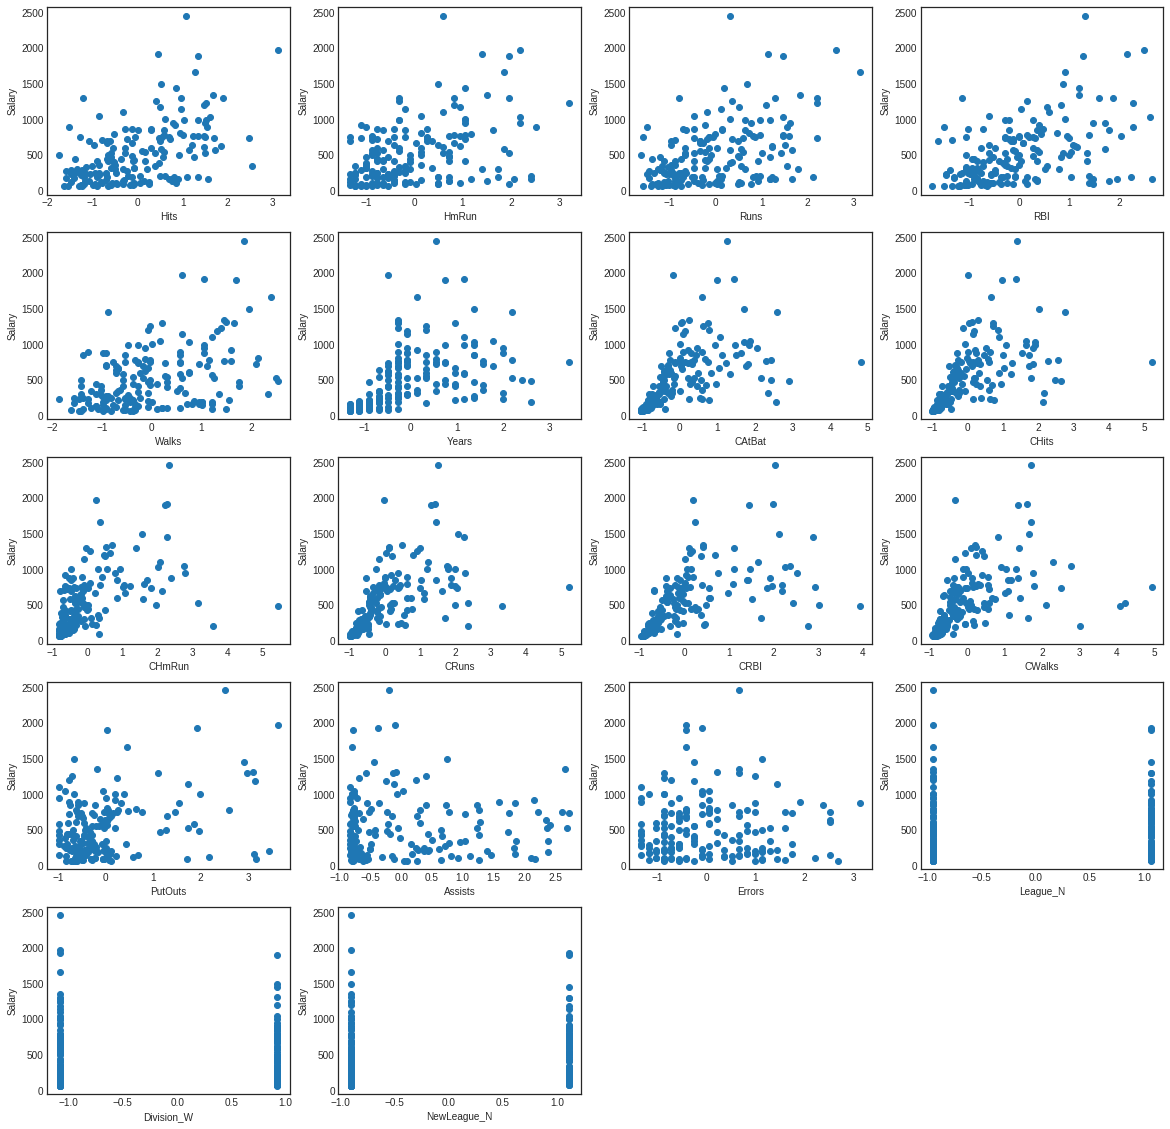

In [51]:
fig1 = plt.figure(figsize=(20,20))
grid = mpl.gridspec.GridSpec(5, 4)
subplots = []

X_nonTestScaled_df = pd.DataFrame(X_nonTestScaled, columns=X.columns)

for i in range(5):
    for j in range(4):
        curr_col = 4*i+(j+1) # convert grid position to array position
        if curr_col < len(X_nonTestScaled_df.columns):
            ax1 = plt.subplot(grid[i,j])
            ax1.scatter(X_nonTestScaled_df.iloc[:,curr_col], y_nonTest)
            ax1.set_xlabel(X_nonTestScaled_df.columns[curr_col])
            ax1.set_ylabel('Salary')
           


### Predictions
Based on the scatterplots above, the 6 features that appear to have the strongest relationship with salary are:
* Hits
* Home Runs
* Career Hits (CHits)
* Career Home Runs (CHmRuns)
* Career At Bats (CAtBat)
* Career RBI (CRBI)

These 6 features appear to have the strongest correlation with salary. The dummy variables all appear to have about an even split for salary so there doesn't appear to be a relation with salary there. Overall, the career performance numbers (Career hits, home runs, at bats, and RBIs) all appear to have the least amount of variance in the relationship between the feature and salary. 

# STEP 2:  Write Function For Best-Subset

In [74]:
def bestSubset(X_nonTest,y_nonTest, k):
    kfeatures = []  #placeholder
    kMSE = []  #placeholder
    
    # insert student code here
    min_avg_MSE = 1000000 #Inital value for finding minimum kMSE
    min_features = []
    max_r2 = 0
    
    features_list = X_nonTest.columns
    feature_combinations = combinations(features_list, k) # Generate p choose k combinations of features
    
    #Generate the subsets: Algorithm step 2a
    for feature_set in feature_combinations:
        X_subset = X_nonTest.loc[:, feature_set] # Select the columns from the dataframe in the feature set
        lin_reg = LinearRegression()
        
        #Algorithm step 2b: Select best model
        # Run 5 fold cross validation with MSE as metric using sklearn cross_validate function
        cv_results = cross_validate(lin_reg, X_subset, y_nonTest, cv=5, scoring=('neg_mean_squared_error', 'r2'))
        # Calculate the mean test score from 5-fold cross validation
        avg_mse = cv_results['test_neg_mean_squared_error'].mean()
        avg_r2 = cv_results['test_r2'].mean()
        
        # Selection of Best model via Greatest R2 score
        if avg_r2 > max_r2:
            min_avg_MSE = avg_mse
            min_features = feature_set
            max_r2 = avg_r2
    #End for
    kfeatures = min_features
    kMSE = min_avg_MSE
    return (kfeatures, kMSE) 

### Metrics

In [ ]:
"""
   This function calculates the RSS for the passed in prediction and truth vectors
"""
def calc_rss(y_true, y_pred):
    y_diff = y_true - y_pred
    rss = np.dot(y_diff, y_diff.T)
    return rss
"""
    This function calculates the MSE for the passed in prediction and truth vectors.
"""
def calc_mse(y_true, y_pred):
    mse = calc_rss(y_true, y_pred)/len(y_true)
    return mse

# STEP 3:  Execute best subset

In [ ]:
#one_feature = bestSubset(X_nonTestScaled_df, y_nonTest, 1)
#two_feature = bestSubset(X_nonTestScaled_df, y_nonTest, 2)
#three_feature = bestSubset(X_nonTestScaled_df, y_nonTest, 3)
#four_feature = bestSubset(X_nonTestScaled_df, y_nonTest, 4)
five_feature = bestSubset(X_nonTestScaled_df, y_nonTest, 5)
six_feature = bestSubset(X_nonTestScaled_df, y_nonTest, 6)

print(five_feature)
print(six_feature)

# STEP 4:  Plot of Avg Crossval MSE for 6 best models with annotated best point

# STEP 5:  Discussion of best subset models

# STEP 6:  Write Function For Forward Stepwise Subset Selection

In [31]:
def forwardStepwiseSubset(X_nonTest,y_nonTest, k):
    kfeatures = []  #placeholder
    kMSE = []  #placeholder
    
    # inster student code here
    
    return (kfeatures, kMSE) 

# STEP 7:  Execute Forward subset

# STEP 8:  Updated Plot of Avg Crossval MSE & best points

# STEP 9:  Discussion of best foward-stepwise models 

# STEP 10: Discussion and comparison of subset selection methods

# STEP 11: Write a function to execute LASSO

In [32]:
def LASSOSubset(X_nonTest,y_nonTest, k):
    #example of logarithmically spaced alphas for LASSO... may need tweaking
    alphas = 10**np.linspace(10,-2,100)*0.5
    kfeatures = [] #placeholder
    kMSE=np.inf  #placeholder
    kalpha = 0  #placeholder
    
    # insert student code here
    
    return (kfeatures, kMSE, kalpha) 

# STEP 12: Execute LASSO

# STEP 13: Updated Plot of Avg Crossval MSE & best points

# STEP 14: Discussion of best foward-stepwise models 

# STEP 15: Answer Customer Questions

## a

## b

END OF ASSIGNMENT